<a href="https://colab.research.google.com/github/SharvariAB/Edge-AI-based-Wafer-Defect-Detection/blob/main/wafer_defect_edge_ai(updated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import shutil
import random

RAW_DATASET = "/content/drive/MyDrive/WM811k_Dataset"
OUTPUT_DATASET = "/content/drive/MyDrive/wafer_dataset"

TRAIN_RATIO = 0.7
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

random.seed(42)


In [3]:
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUTPUT_DATASET, split), exist_ok=True)


In [4]:
for class_name in os.listdir(RAW_DATASET):
    class_path = os.path.join(RAW_DATASET, class_name)

    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(TRAIN_RATIO * total)
    val_end   = train_end + int(VAL_RATIO * total)

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, split_images in splits.items():
        split_class_dir = os.path.join(OUTPUT_DATASET, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img in split_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copy(src, dst)


In [5]:
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()}")
    split_path = os.path.join(OUTPUT_DATASET, split)
    for cls in os.listdir(split_path):
        print(cls, ":", len(os.listdir(os.path.join(split_path, cls))))



TRAIN
Scratch : 70
Edge Local : 72
Local : 70
random : 70
none : 70
near full : 66
Edge Ring : 71
Donut : 71
Center : 70

VAL
Scratch : 15
Edge Local : 15
Local : 15
random : 15
none : 15
near full : 14
Edge Ring : 15
Donut : 15
Center : 15

TEST
Scratch : 15
Edge Local : 16
Local : 15
random : 15
none : 15
near full : 15
Edge Ring : 16
Donut : 16
Center : 15


In [6]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((96,96)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

DATASET_PATH = "/content/drive/MyDrive/wafer_dataset"

train_ds = datasets.ImageFolder(DATASET_PATH + "/train", transform=transform)
val_ds   = datasets.ImageFolder(DATASET_PATH + "/val", transform=transform)
test_ds  = datasets.ImageFolder(DATASET_PATH + "/test", transform=transform)

print(train_ds.classes)


['Center', 'Donut', 'Edge Local', 'Edge Ring', 'Local', 'Scratch', 'near full', 'none', 'random']


In [7]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((96,96)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

DATASET_PATH = "/content/drive/MyDrive/wafer_dataset"

train_ds = datasets.ImageFolder(DATASET_PATH + "/train", transform=transform)
val_ds   = datasets.ImageFolder(DATASET_PATH + "/val", transform=transform)
test_ds  = datasets.ImageFolder(DATASET_PATH + "/test", transform=transform)

print(train_ds.classes)


['Center', 'Donut', 'Edge Local', 'Edge Ring', 'Local', 'Scratch', 'near full', 'none', 'random']


In [8]:
import torch
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [9]:
import torch.nn as nn
import torch.nn.functional as F

NUM_CLASSES = len(train_ds.classes)

class WaferCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 96 → 48
        x = self.pool(F.relu(self.conv2(x)))   # 48 → 24
        x = self.pool(F.relu(self.conv3(x)))   # 24 → 12
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [10]:
model = WaferCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [11]:
EPOCHS = 15

for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    train_loss = 0

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ---- VALIDATION ----
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss/len(train_dl):.4f} "
          f"Val Acc: {val_acc:.4f}")


Epoch [1/15] Train Loss: 1.7048 Val Acc: 0.5672
Epoch [2/15] Train Loss: 1.0827 Val Acc: 0.5746
Epoch [3/15] Train Loss: 0.7576 Val Acc: 0.8582
Epoch [4/15] Train Loss: 0.5042 Val Acc: 0.8060
Epoch [5/15] Train Loss: 0.3951 Val Acc: 0.8134
Epoch [6/15] Train Loss: 0.2674 Val Acc: 0.7836
Epoch [7/15] Train Loss: 0.1428 Val Acc: 0.8284
Epoch [8/15] Train Loss: 0.0769 Val Acc: 0.8358
Epoch [9/15] Train Loss: 0.0500 Val Acc: 0.8358
Epoch [10/15] Train Loss: 0.0898 Val Acc: 0.8507
Epoch [11/15] Train Loss: 0.0274 Val Acc: 0.8507
Epoch [12/15] Train Loss: 0.0116 Val Acc: 0.8134
Epoch [13/15] Train Loss: 0.0068 Val Acc: 0.8358
Epoch [14/15] Train Loss: 0.0030 Val Acc: 0.8358
Epoch [15/15] Train Loss: 0.0015 Val Acc: 0.8507


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_dl:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall    = recall_score(y_true, y_pred, average="weighted")
cm        = confusion_matrix(y_true, y_pred)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("Confusion Matrix:\n", cm)


Accuracy : 0.8115942028985508
Precision: 0.8072217655178013
Recall   : 0.8115942028985508
Confusion Matrix:
 [[12  1  0  0  1  0  0  1  0]
 [ 1 14  0  0  0  0  0  1  0]
 [ 0  0 13  1  0  2  0  0  0]
 [ 0  0  0 16  0  0  0  0  0]
 [ 0  1  0  0  9  3  0  1  1]
 [ 0  0  1  0  6  7  0  0  1]
 [ 0  0  0  0  0  0 15  0  0]
 [ 1  0  1  0  0  0  0 13  0]
 [ 0  1  0  0  0  0  1  0 13]]


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [14]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [15]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[12  1  0  0  1  0  0  1  0]
 [ 1 14  0  0  0  0  0  1  0]
 [ 0  0 13  1  0  2  0  0  0]
 [ 0  0  0 16  0  0  0  0  0]
 [ 0  1  0  0  9  3  0  1  1]
 [ 0  0  1  0  6  7  0  0  1]
 [ 0  0  0  0  0  0 15  0  0]
 [ 1  0  1  0  0  0  0 13  0]
 [ 0  1  0  0  0  0  1  0 13]]


<Figure size 800x800 with 0 Axes>

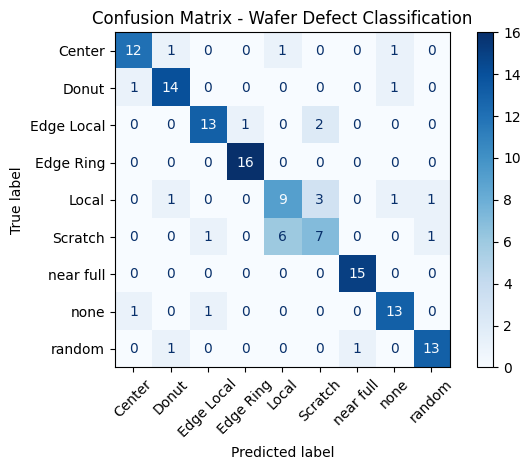

In [16]:
class_names = test_ds.classes  # Automatically from ImageFolder

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Wafer Defect Classification")
plt.tight_layout()
plt.show()


<Figure size 800x800 with 0 Axes>

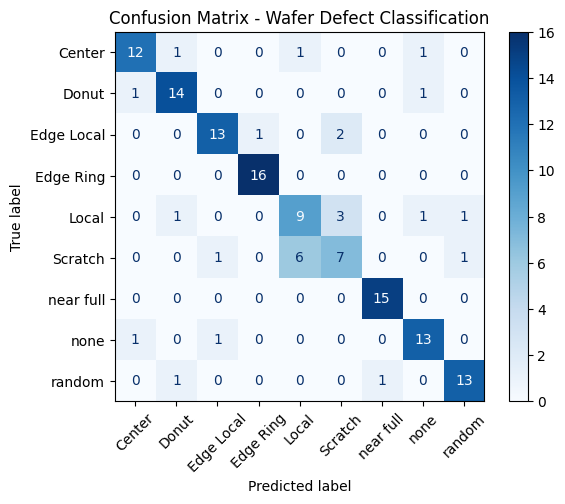

In [17]:
plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Wafer Defect Classification")
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


<Figure size 800x800 with 0 Axes>

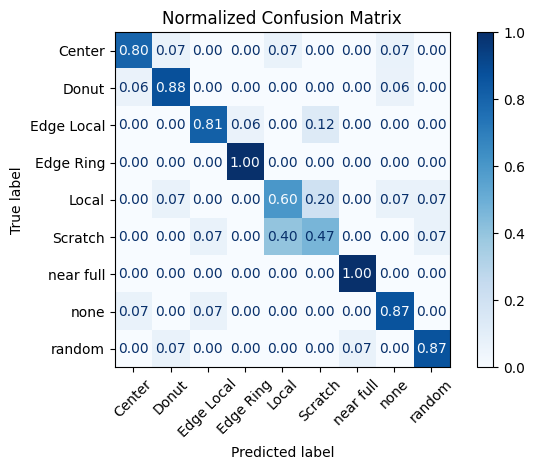

In [18]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format=".2f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()
